In [1]:
import numpy as np
import matplotlib.pyplot as plt
from env.dynaQ_maze import DynaQMaze

## Setup the environment

In [2]:
start_location = (2, 0)
target_location = (0, 8)
rows = 6
columns = 9
block_positions = [[1, 2], [2, 2], [3, 2], [4, 5], [0, 7], [1, 7], [2, 7]]
env = DynaQMaze(rows=rows, 
                columns=columns, 
                block_positions=block_positions, 
                start_location=start_location, 
                target_location=target_location)

num_actions = env.action_space.n

## Tabular Dyna-Q

In [3]:
def epsilon_greedy(Q: np.ndarray, epsilon:float):
    num_actions = Q.shape[-1]
    if np.random.rand() < epsilon:
        return int(np.random.choice(num_actions))
    
    max_value = Q.max()
    candidates = np.flatnonzero(Q == max_value)
    return int(np.random.choice(candidates))

def tabular_dynaQ(
    env: DynaQMaze,
    Q_init: np.ndarray,
    model: np.ndarray,
    episodes: int=1,
    planning_steps:int=0,
    gamma:float=1.0,
    alpha:float=0.1,
    epsilon:float=0.1
):
    visited = []
    Q = Q_init.copy()
    model = model.copy()
    steps_per_episode = []

    for episode in range(episodes):
        env.reset()
        step = 0
        while not env.is_terminated():
            state = env.observation['agent'].tolist()
            action = epsilon_greedy(Q=Q[*state], epsilon=epsilon)
            feedback = env.step(action)
            new_state = feedback[0]['agent'].tolist()
            reward = feedback[1]

            # Direct RL
            Q[*(state + [action])] += alpha * (reward + gamma * np.max(Q[*new_state]) - Q[*(state + [action])])

            # Model learning
            idx = tuple(state + [action])
            model[idx] = np.array([new_state[0], new_state[1], reward])
            visited.append(state + [action])

            for _ in range(planning_steps):
                rand_index = np.random.choice(len(visited))
                rand_state_action = visited[rand_index]
                rand_new_statex, rand_new_statey, rand_reward = model[*rand_state_action].tolist()
                rand_new_state = [int(rand_new_statex), int(rand_new_statey)]
                # Planning
                Q[*rand_state_action] += alpha * (rand_reward + gamma * np.max(Q[*rand_new_state]) - Q[*rand_state_action])
            step += 1
        
        steps_per_episode.append(step)
    
    return Q, model, steps_per_episode

In [4]:
Q_init = np.zeros(shape=(rows, columns, num_actions))
model_init = np.zeros(shape=(rows, columns, num_actions, 3))
gamma = 0.95
epsilon = 0.1
alpha = 0.1
episodes = 50
planning_steps = [0, 5, 50]
runs = 30
results = {}

for n in planning_steps:
    print("n =", n)
    mean_steps_per_episode = np.zeros((episodes,), dtype=np.float32)

    for run in range(runs):
        Q, model, steps_per_episode = tabular_dynaQ(
            env=env,
            Q_init=Q_init,
            model=model_init,
            episodes=episodes,
            planning_steps=n,
            gamma=gamma, 
            alpha=alpha,
            epsilon=epsilon
        )
        mean_steps_per_episode += steps_per_episode
        results[n] = mean_steps_per_episode
        print(f"\rRun: {run + 1:<3}", end='')
    print()
    mean_steps_per_episode /= runs

n = 0
Run: 30 
n = 5
Run: 30 
n = 50
Run: 30 


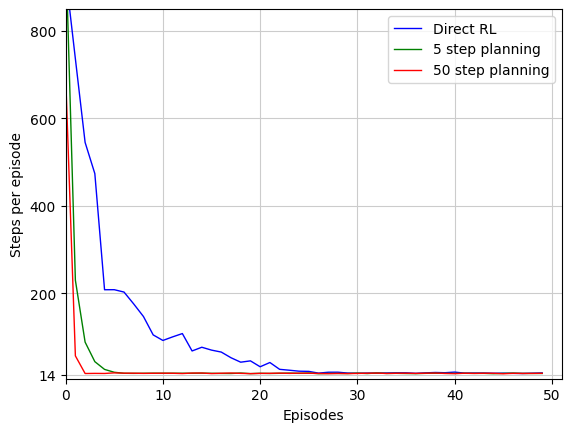

In [5]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(results[0], label='Direct RL', c='blue', linewidth=1)
ax.plot(results[5], label='5 step planning', c='green', linewidth=1)
ax.plot(results[50], label='50 step planning', c='red', linewidth=1)
ax.set_ylim([5, 850])
ax.set_yticks([14, 200, 400, 600, 800]);
ax.set_xlim([0, 51])
ax.grid(c="#ccc")
ax.legend();
ax.set_xlabel("Episodes")
ax.set_ylabel("Steps per episode");